In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
rm -f ../data/AmpC_screen_table__withscores.csv

In [49]:
%%bash

if ! [[ -f ../data/AmpC_screen_table__withscores.csv ]]; then
    sed -e '/no_score/d' ../data/AmpC_screen_table.csv > ../data/AmpC_screen_table__withscores.csv
fi

if ! [[ -f ../data/D4_screen_table__withscores.csv ]]; then
    sed -e '/no_score/d' ../data/D4_screen_table.csv > ../data/D4_screen_table__withscores.csv
fi

In [50]:
%%time

datasets = {'AmpC':'../data/AmpC_screen_table__withscores.csv',
            'D4':'../data/D4_screen_table__withscores.csv'
           }

dfs = []
for name, path in datasets.items():
    df = dd.read_csv(path)
    df['proj'] = name
    dfs.append(df)

df = dd.concat(dfs).compute(num_workers = 16)

CPU times: user 5min 15s, sys: 44.8 s, total: 6min
Wall time: 4min 27s


/tmp/ipykernel_129227/3618675794.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.query('dockscore < 0').hist('dockscore', bins=100, by='proj', ax=ax)


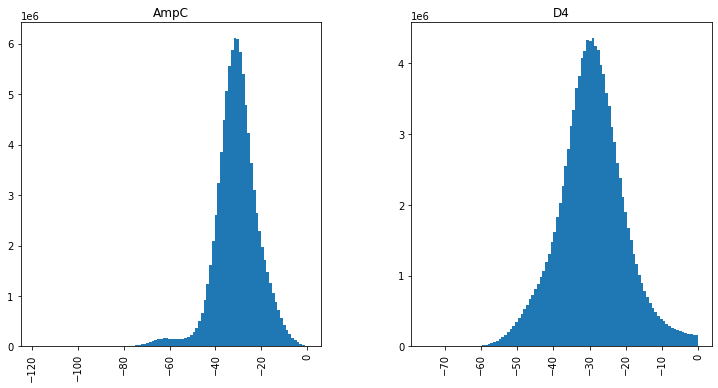

In [55]:
fig = plt.figure(figsize = (12,6))
ax = fig.gca()
df.query('dockscore < 0').hist('dockscore', bins=100, by='proj', ax=ax)
plt.savefig('../figures/Figure_1.png')

In [67]:
df.value_counts('proj')

proj
D4      138312677
AmpC     96214206
dtype: int64